# Analysis of WASP-189 (Phase Curve) using `pycheops`

In the following notebook, we will analyse the data from `CHEOPS` visit 1 data of HD106315b using `pycheops`.

The method is similar to that used in the analysis of KELT-11b data ([https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb](https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
from pycheops.models import ThermalPhaseModel
import astropy.units as u
from lmfit import minimize
from uncertainties import UFloat
import re
from pycheops.utils import phaser

## Downloading the data

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR100036_TG000701_V0200.tgz
 PI name     : Brice-Olivier DEMORY
 OBS ID      : 1145201
 Target      : WASP-189
 Coordinates : 15:02:44.87 -03:01:53.0
 Spec. type  : A6V
 G magnitude : 6.55 +- 0.00
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR100036_TG000701_V0200-DEFAULT.fits
Time stored relative to BJD = 2459016
Aperture radius used = 25 arcsec
UTC start:  2020-06-15T18:07:40
UTC end:    2020-06-18T21:07:01
Visit duration: 269961 s
Exposure time: 7 x 4.8 s
Number of non-flagged data points: 4758
Efficiency (non-flagged data): 59.2 %
Light curve corrected for flux from background stars
Mean counts = 140556171.2
Median counts = 140629390.3
RMS counts = 222219.7 [1580 ppm]
Median standard error = 11901.2 [85 ppm]
Median background = 262452 e-/pxl
Mean contamination = 733.0 ppm
Mean smearing correction = 60.4 ppm

Rejected 12 points more than 5.0 x MAD = 356 ppm from the median


/home/jayshil/anaconda3/lib/python3.8/site-packages/pycheops-0.9.17-py3.8.egg/pycheops/dataset.py:426: UserWarning: No metadata in file /home/jayshil/.local/share/pycheops/CH_PR100036_TG000701_V0200.tgz
  warnings.warn(msg)


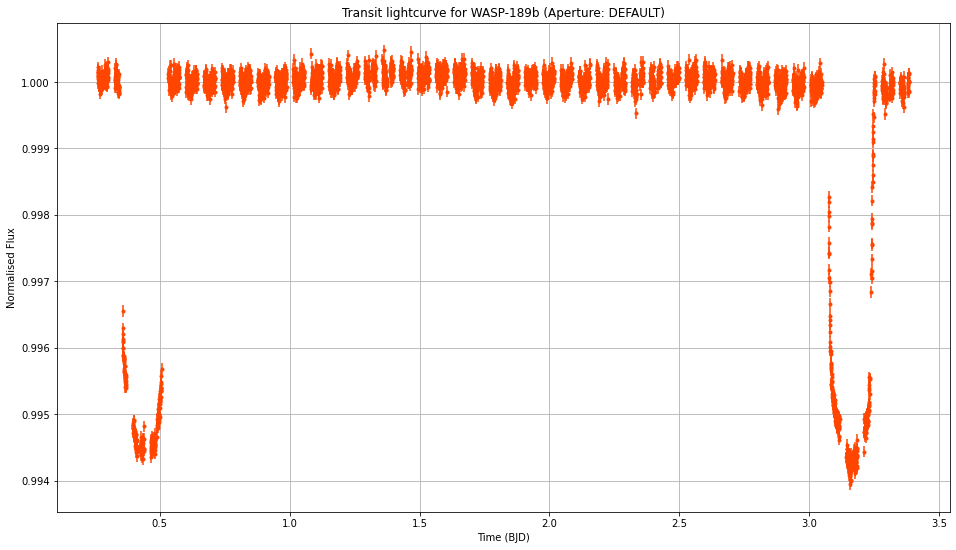

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR100036_TG000701_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='DEFAULT', decontaminate=True)#, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
tim, fl, fle = dd.clip_outliers(verbose=True);

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for WASP-189b (Aperture: DEFAULT)')
plt.grid()

### Planetary check

We may want to check the position of various planetary bodies with respect to the target star, because if some of the bodies is very near to the target star then we may want to correct for their effects.

In [3]:
dd.planet_check()

BJD = 2459016.260447496
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     01:28:57.05  +04:05:47.0      42.4
Mars     23:35:07.42  -05:41:00.0      82.0
Jupiter  19:49:36.55  -21:18:28.3      66.3
Saturn   20:11:47.02  -20:10:17.7      73.7
Uranus   02:26:57.74  +14:03:48.3     165.0
Neptune  23:27:22.67  -04:40:49.8     123.8


## Stellar and Planetary properties

A knowledge of the stellar and planetary property of the system under investigation can proved to be useful while analysing the system. We can use some of the properties as priors in our analysis. In `pycheops` there are some in-build tools  available which ca go through the available stellar and planetary catalogues (like SWEET-Cat, or DACE) to give us the properties. Below, we show how to access such properties.

In [4]:
# For planetary properties
# This cell is copied from pycheops examples notebook
# The planet properties will not provide good results
# Hence, we will use ExoCTK to get planetary parameters.
"""
try: 
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=True)
except:
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=False, query_tepcat=False,
                                    depth = ufloat(298.909, 20.791),   # PPM
                                    width = ufloat(0.1572,0.0034),  # days (that means that is transit duration -- in days)
                                    ecosw=0.,#ufloat(-0.0040, 0.0490), 
                                    esinw=0.,#ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2457586.5487, 0.0029),
                                    P = ufloat(9.55237, 0.00089))
    
print(hd106315b)
"""
# Using ExoCTK to get planetary properties
rprs = np.random.normal(0.060907361661750425, 0.003144594526637345, 10000)
dep, dep_err = np.mean((rprs**2)*1e6), np.std((rprs**2)*1e6)

Well..., apparently, I cannot (even after studying two semesters at Geneva) access DACE-Planets. No problem --- we have TEPCat at our service. We derived parameters from there. We can now try searching for the host star.

In [5]:
"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(8000, 80, 10000)
logg = np.random.normal(3.9, 0.2, 10000)
mh = np.random.normal(0.29, 0.13, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])

It seems that the program would return nan to h1 and h2 because the temperature is out of range of the grid. So, we will let free the h1 and h2 in the analysis.

We have it! Here `h_1` and `h_2` are power2 law limb darkening coefficients.

## Renormalising the lightcurve

It already seems pretty flatten -- and applying the function would only reduce the quality of the data.

[False False False ... False False False]

Masked 816 points


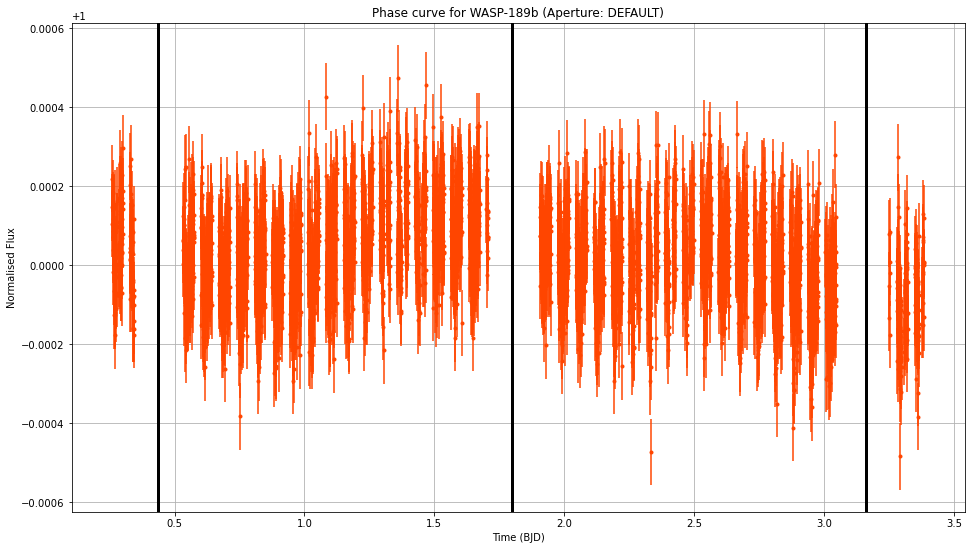

In [6]:
# This code is taken from the pycheops example notebook
P = 2.7240338
BJD_0 = 2456706.4558
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + (cycle+0)*P
T_1 = BJD_0 - dd.bjd_ref + (cycle+1)*P
T_ec = T_0 + (P/2)

D = dep/1e6  # Depth stored in ppm
W = 0.1819/P    # Width stored in days

try:
    f_c = 0.#np.sqrt(0.093)*np.sin(67.0*np.pi/180)
    f_s = 0.#np.sqrt(0.093)*np.cos(67.0*np.pi/180)
except:
    # From Pepper et al., 2017
    ecosw = 0.#ufloat(-0.004,0.05099)
    esinw = 0.#ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = 0.#esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = 0.#ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


# Let's take data from first transit only
"""
mask1 = tim > T_0-(W*P/2)
mask2 = tim < T_0+(W*P/2)
mask3 = tim > T_ec - (W*P/2)
mask4 = tim < T_ec + (W*P/2)
mask5 = tim > T_1-(W*P/2)
mask6 = tim < T_1+(W*P/2)
"""
mask = np.zeros(len(tim), dtype=bool)
for i in range(len(tim)):
    if (tim[i] > T_0-(W*P/2)) and (tim[i] < T_0+(W*P/2)):
        mask[i] = True
    elif (tim[i]>T_ec-(W*P/2)) and (tim[i]<T_ec+(W*P/2)):
        mask[i] = True
    elif (tim[i]>T_1-(W*P/2)) and (tim[i]<T_1+(W*P/2)):
        mask[i] = True

print(mask)

tim, fl, fle = dd.mask_data(mask)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(T_ec, c='k', lw=3)
plt.axvline(x=T_0, c='k', lw=3)
plt.axvline(x=T_1, c='k', lw=3)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Phase curve for WASP-189b (Aperture: DEFAULT)')
plt.grid()

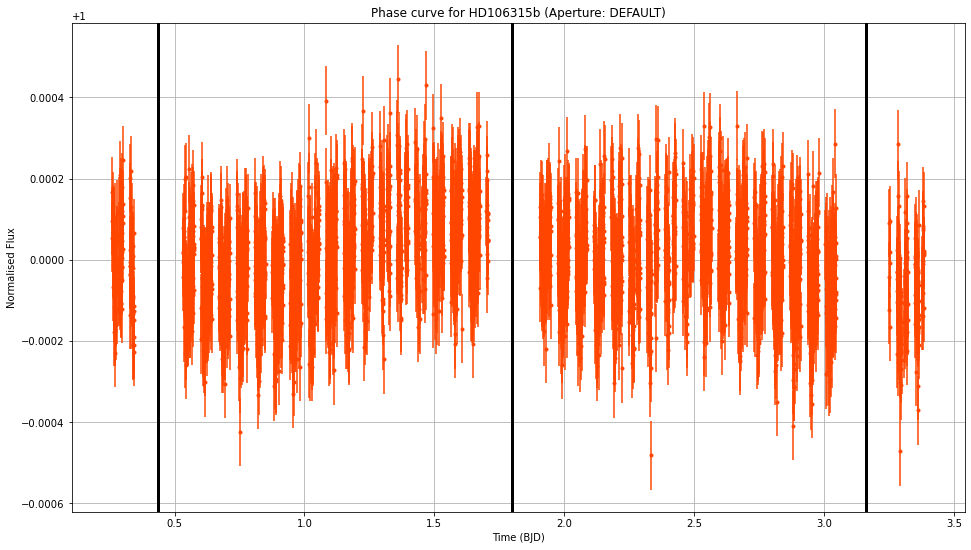

In [7]:
tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(T_ec, c='k', lw=3)
plt.axvline(x=T_0, c='k', lw=3)
plt.axvline(x=T_1, c='k', lw=3)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Phase curve for HD106315b (Aperture: DEFAULT)')
plt.grid()

## Detrending (or, decorrelating) the dataset

To perform this operation of detrending we may want to look at diagnostic report for this observations. The diagnostic report consist of various plots of flux as a function of several instrumental properties like roll angle of the spacecraft, centroid position etc. This would enable us to see if there is any trend going on with instruments so that we can take care of it. So, first let's see the diagnostic report...

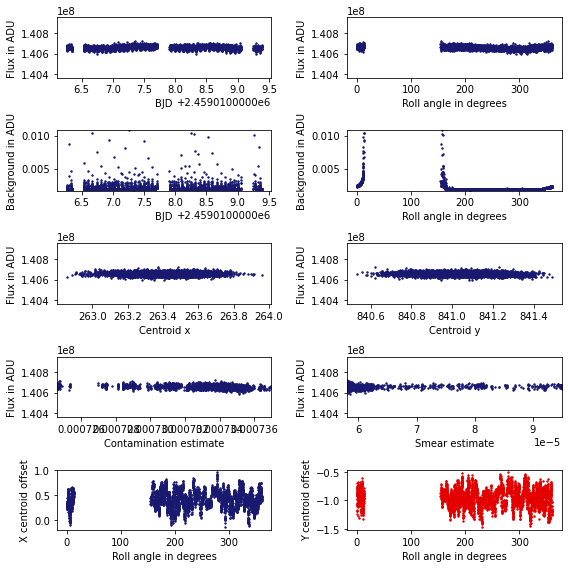

In [8]:
dd.diagnostic_plot()

In [9]:
dd.should_I_decorr()

Decorrelate in dfdt dfdx dfdy dfdsinphi dfdcosphi dfdbg dfdcontam dfdsmear d2fdt2 d2fdx2 d2fdy2 dfdsin2phi dfdcos2phi using decorr, lmfit_transt, or lmfit_eclipse functions.


(-69679.19758186695,
 ['dfdt',
  'dfdx',
  'dfdy',
  'dfdsinphi',
  'dfdcosphi',
  'dfdbg',
  'dfdcontam',
  'dfdsmear',
  'd2fdt2',
  'd2fdx2',
  'd2fdy2',
  'dfdsin2phi',
  'dfdcos2phi'])

Fit Report
[[Model]]
    Model(factor)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 3786
    # variables        = 7
    chi-square         = 4.3226e-05
    reduced chi-square = 1.1439e-08
    Akaike info crit   = -69224.8388
    Bayesian info crit = -69181.1653
[[Variables]]
    c:           1.00004167 +/- 2.6486e-06 (0.00%) (init = 1)
    dfdt:       -7.9223e-07 +/- 2.0359e-06 (256.98%) (init = 0)
    d2fdt2:      0 (fixed)
    dfdbg:       2.5143e-05 +/- 6.7652e-05 (269.07%) (init = 0)
    dfdcontam:   0 (fixed)
    dfdsmear:    0 (fixed)
    ramp:        0 (fixed)
    dfdx:       -5.9666e-06 +/- 5.6118e-06 (94.05%) (init = 0)
    dfdy:       -2.4573e-05 +/- 5.2427e-06 (21.34%) (init = 0)
    d2fdxdy:     0 (fixed)
    d2fdx2:      0 (fixed)
    d2fdy2:      0 (fixed)
    dfdcosphi:  -1.7471e-05 +/- 2.1772e-06 (12.46%) (init = 0)
    dfdsinphi:   1.0039e-04 +/- 4.4811e-06 (4.46%) (init = 0)
    dfdcos2phi:  0 (fixed)
    dfd

(array([1.00000054, 1.00005135, 1.00014027, ..., 0.99984543, 1.00008665,
        0.99997397]),
 array([8.46489411e-05, 8.46471418e-05, 8.46484955e-05, ...,
        8.46188471e-05, 8.46288237e-05, 8.46242082e-05]))

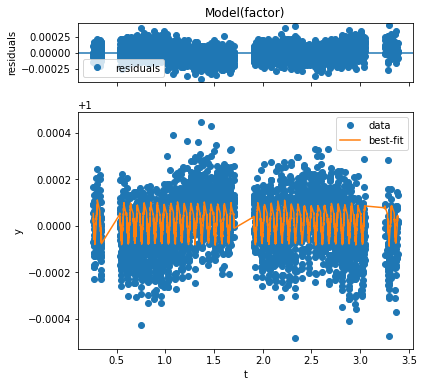

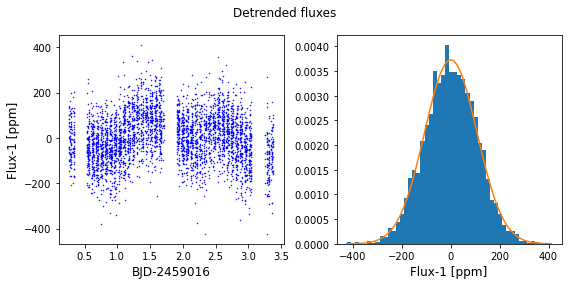

In [10]:
dd.decorr(dfdx=True, dfdy=True, dfdt=True, dfdbg=True, dfdsinphi=True, dfdcosphi=True)

# Modelling the phasecurve

In [11]:
# Defining a chi square minimization function
def _chisq_prior(pars, *args):
    r = (fl - Model.eval(pars, t = tim))/fle
    for p in pars:
        u = pars[p].user_data
        if isinstance(u, UFloat):
            r = np.append(r, (u.n - pars[p].value)/u.s)
    return r

In [12]:
# Creating a model
Model = ThermalPhaseModel()

# Adding parameters to the model
pars = Model.make_params()
pars.add("P", value = 2.7240338, vary=False)
pars.add("T_0", value = T_0, vary=False)
pars.add("a_th", value = 0.01, vary = True)
pars.add("b_th", value = -0.01, vary = True)
pars.add("c_th", value = 0.01, vary = True)

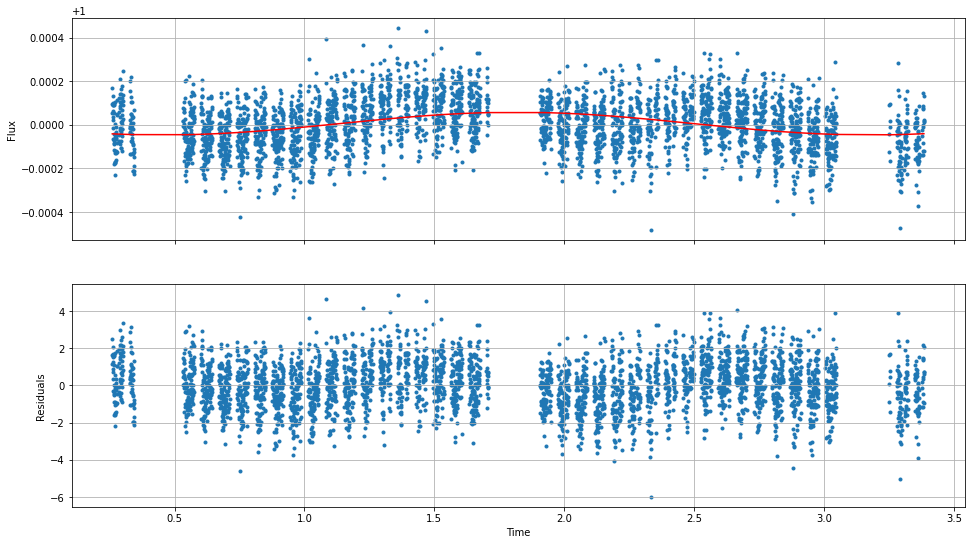

In [13]:
result = minimize(_chisq_prior, pars, nan_policy = "propagate", args = (Model, tim, fl, fle))
flux_model = Model.eval(result.params, t = tim)
residuals = result.residual

figure, ax = plt.subplots(2, 1, sharex = True, figsize=(16,9))
ax[0].scatter(tim, fl, marker='.')
ax[0].plot(tim, flux_model, "r")
ax[1].scatter(tim, residuals, marker='.')
ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Residuals")
ax[1].set_xlabel("Time")
ax[1].grid()
ax[0].grid()

In [14]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
T_0,0.43646240,0.00000000,(0.00%),0.43646240011230475,-inf,inf,False,
P,2.72403380,0.00000000,(0.00%),2.7240338,-inf,inf,False,
a_th,1.0421e-04,5.3272e-06,(5.11%),0.01,-inf,inf,True,
b_th,-4.2990e-06,4.9670e-06,(115.54%),-0.01,-inf,inf,True,
c_th,0.99995519,3.9494e-06,(0.00%),0.01,-inf,inf,True,
A,1.0430e-04,5.3225e-06,(5.10%),0.01414213562373095,-inf,inf,False,"hypot(a_th,b_th)"
Fmax,1.00005729,1.8262e-06,(0.00%),0.017071067811865476,0.00000000,inf,False,c_th+(a_th+b_th+A)/2
Fmin,0.99995299,0.00000000,(0.00%),0.0029289321881345257,0.00000000,inf,False,Fmax - A
ph_max,-0.49343801,0.00758721,(1.54%),-0.375,-inf,inf,False,"arctan2(b_th,-a_th)/(2*pi)"
